In [448]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import re #regex
import os
from datetime import date, datetime, timedelta
import math
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
import seaborn as sns
# Set style & figures inline
sns.set()
%matplotlib inline

## Web Scrapping Functions

In [449]:
# Extracts data from the webpage using lxml.html
def extract_table(url,xpath_all,contains_header):
    
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url)
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)

    col_all=[]
    nrows=[] # number of rows for each table
    
    for xpath in xpath_all:
        print("Path used in collecting data: {}".format(xpath))
        #Parse data that are stored between <tr>..</tr> of HTML
        tr_elements = doc.xpath(xpath)
        
        #Check the number of columns of the first 12 rows
        print("Number of columns of the table:")
        print([len(T) for T in tr_elements[:18]])

        #Create empty list
        #tables that store a header (if there's one) and data
        #assuming all tables have the same header
        col=[]  

        ## Getting header
        i=0
        #For each row, store each first element (header)
        #and an empty list
        print("Table Header:")
        for t in tr_elements[0]:
            if contains_header==True:
                name=t.text_content()
            else:
                name=contains_header[i]
            i+=1
            print('%d:"%s"'%(i,name))
            col.append((name,[]))
            
        ## Getting data
        if contains_header==True:
            start_ind = 1
        else:
            start_ind = 0

        #nrows_current = 0
        for j in range(start_ind,len(tr_elements)):

            # break if reaching end of table
            #if len(tr_elements[j]) != len(tr_elements[0]):
            if j > 14:
                break
            i = 0    
            for ele in tr_elements[j].iterchildren():
                data = ele.text_content().strip()

                #check data
                p1 = re.search("^[A-Za-z]+", data)
                p2 = re.search('^[0-9,]+[\\n]*', data)

                if p1:
                    col[i][1].append(data)
                elif p2:
                    value = data[:p2.span()[1]].replace(",","")
                    if (re.search("\\n", value)):
                        value = value[:-1]
                    col[i][1].append(int(value))

                #Increment i for the next column
                i+=1
            
        col_all.append(col)
    return col_all

# Stores extracted data into dataframe(s)
def create_dataframe(table,num_table):

    df_all = pd.DataFrame()

    for t in range(0,num_table):
        Dict={title:column for (title,column) in table[t]}
        df=pd.DataFrame(Dict)
        df['Date'] = date.today()
        df_all=df_all.append(df,ignore_index=True)

    return df_all

## Extract data from the web

In [450]:
# Obtained data from the following website
url='https://www.covid-19canada.com'
#xpath1_1='//tr'
xpath1_1='//table[@id="canada-board"]//tr'
header = ["Province", "Total Confirmed", "Total Deaths", "Total Recovered", "Total Active"]
data = extract_table(url,[xpath1_1], contains_header=header)

print(data)

Path used in collecting data: //table[@id="canada-board"]//tr
Number of columns of the table:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Table Header:
1:"Province"
2:"Total Confirmed"
3:"Total Deaths"
4:"Total Recovered"
5:"Total Active"
[[('Province', ['Prov.', 'Total', 'BC', 'ON', 'QC', 'AB', 'MB', 'NB', 'SK', 'PEI', 'NL', 'NS', 'YT', 'NT', 'NU']), ('Total Confirmed', ['Total Confirmed', 1309335, 137223, 502171, 360982, 213635, 43143, 2024, 43673, 187, 1173, 4301, 84, 120, 606]), ('Total Deaths', ['Total Deaths', 24804, 1627, 8405, 11017, 2123, 1000, 41, 508, 0, 6, 71, 2, 0, 4]), ('Total Recovered', ['Total Recovered', 1208539, 129524, 464531, 342170, 186550, 38203, 1859, 41149, 179, 1081, 2609, 80, 63, 528]), ('Total Active', ['Total Active', 75801, 5885, 29235, 7795, 24962, 3940, 124, 2016, 8, 82, 1621, 2, 57, 74])]]


In [451]:
df_1 = create_dataframe(data,len([xpath1_1]))

#remvoe the first row (header)
df_1.drop(labels = [0], axis = 0, inplace = True)
df_1.reset_index(drop = True, inplace = True)
print(df_1)

   Province Total Confirmed Total Deaths Total Recovered Total Active  \
0     Total         1309335        24804         1208539        75801   
1        BC          137223         1627          129524         5885   
2        ON          502171         8405          464531        29235   
3        QC          360982        11017          342170         7795   
4        AB          213635         2123          186550        24962   
5        MB           43143         1000           38203         3940   
6        NB            2024           41            1859          124   
7        SK           43673          508           41149         2016   
8       PEI             187            0             179            8   
9        NL            1173            6            1081           82   
10       NS            4301           71            2609         1621   
11       YT              84            2              80            2   
12       NT             120            0           

## Combine new daily extracted data to previous data

In [452]:
### Export the current df to existing file (previous data)
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data")
os.makedirs(save_path, exist_ok = True)

num_dataset = len(df_1.index)


for i in range(num_dataset):
    temp_df = df_1.loc[df_1[df_1.columns[0]] == df_1.loc[i][df_1.columns[0]]]

    #load current df and then perform merge before saving
    file_fullpath = os.path.join(save_path,df_1.loc[i][df_1.columns[0]] + ".csv")
    if os.path.exists(file_fullpath):
        orig_dataset = pd.read_csv(file_fullpath)    
        
        #reindex new df to match with existing data
        temp_df.reindex(columns=orig_dataset.columns)
        
        new_dataset = pd.merge(orig_dataset, temp_df, how = 'outer', 
                               on = list(orig_dataset.columns))
        new_dataset.drop_duplicates(subset=['Total Confirmed','Date'], 
                                    keep = 'first', inplace = True)
        #print(new_dataset)
        new_dataset.to_csv(file_fullpath, index = False)
    else:
        temp_df.to_csv(file_fullpath, index = False)

## Examine the data

In [453]:
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data")

# select the provinces to look at
target = ['Total', 'ON', 'QC', 'BC', 'AB']

df = []
# import updated data
for i in range(len(target)):
    file_fullpath = os.path.join(save_path, target[i] + ".csv")
    df_temp = pd.read_csv(file_fullpath)
    #df_temp.drop_duplicates(subset=['Total Confirmed','Date'], keep = 'first', inplace = True)
    df_temp.drop_duplicates(subset=['Date'], keep = 'last', inplace = True)
    #print(df_temp.tail(2))
    #continue
    df_temp = df_temp.set_index('Date')
    df.append(df_temp)
    
    #print('\n\n****** ' + df_temp['Province'][0] + ' ******')
    #print(df_temp.tail(5))
    #df_temp.iloc[:, 1:5].plot(figsize=(20,10), style='o', ms=10, fontsize=20, rot = 45)
    #plt.xlabel('Date', fontsize=20);
    #plt.ylabel('Patients count', fontsize=20);
    #plt.title('Time Series for ' + target[i], fontsize=20)
    #plt.show()

## 1st Model Fitting: Gaussian

In [477]:
# function for fitting (normal distribution function)
def func_normal(x,a,x0,sigma):
    return (a/sigma)*np.exp(-(x-x0)**2/(2*sigma**2))

# specify the formats of dates in the dataset
def try_parsing_date(text):
    for fmt in ('%Y-%m-%d', '%d-%m-%Y'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')
    
# dividing zero function
def division(r,d):
    return (r / d if d != 0 else r)

In [455]:
# computes the weekly average
def getWeeklyAverage(xdata, x_data_in_day, y_data_change_per_day, year_start):
    #year_start = 2020
    
    df = pd.DataFrame(data = {'Date': xdata, 
                              'Date_Num': x_data_in_day, 
                              'Daily_Increase': y_data_change_per_day})
    df['Date_formatted'] = pd.to_datetime(df['Date'], format="%d-%m-%Y",  errors='coerce')
    mask = df.Date_formatted.isnull()
    df.loc[mask, 'Date_formatted'] = pd.to_datetime(df[mask]['Date'], 
                                                    format="%Y-%m-%d", errors='coerce')
    #df['Week'] = df['Date_formatted'].dt.week
    df['Week'] = df['Date_formatted'].dt.isocalendar().week #get week number
    
    df.loc[(df['Date_formatted'].dt.year > year_start) & 
                   (df['Week'] < date(year_start,12,31).isocalendar()[1]), 'Week'] = \
    df['Date_formatted'].dt.isocalendar().week + date(year_start, 12, 31).isocalendar()[1]
    
    df['Week_midpoint'] = df.groupby('Week')[['Date_Num']].transform('median')
    
    #print(df.tail(10))
    #print(df.groupby('Week')['Date_formatted'].transform('min'))
    
    weekly_avg = df.groupby('Week')[['Week_midpoint','Daily_Increase']].mean()
    #print(weekly_avg)
    return weekly_avg




****** Total ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-05-09    Total        1284153.0       24621.0        1179100.0   
2021-05-10    Total        1290176.0       24651.0        1185498.0   
2021-05-11    Total        1296941.0       24706.0        1193566.0   
2021-05-12    Total        1302852.0       24758.0        1201372.0   
2021-05-13    Total        1309335.0       24804.0        1208539.0   

            Total Active  
Date                      
2021-05-09       80231.0  
2021-05-10       79826.0  
2021-05-11       78466.0  
2021-05-12       76521.0  
2021-05-13       75801.0  


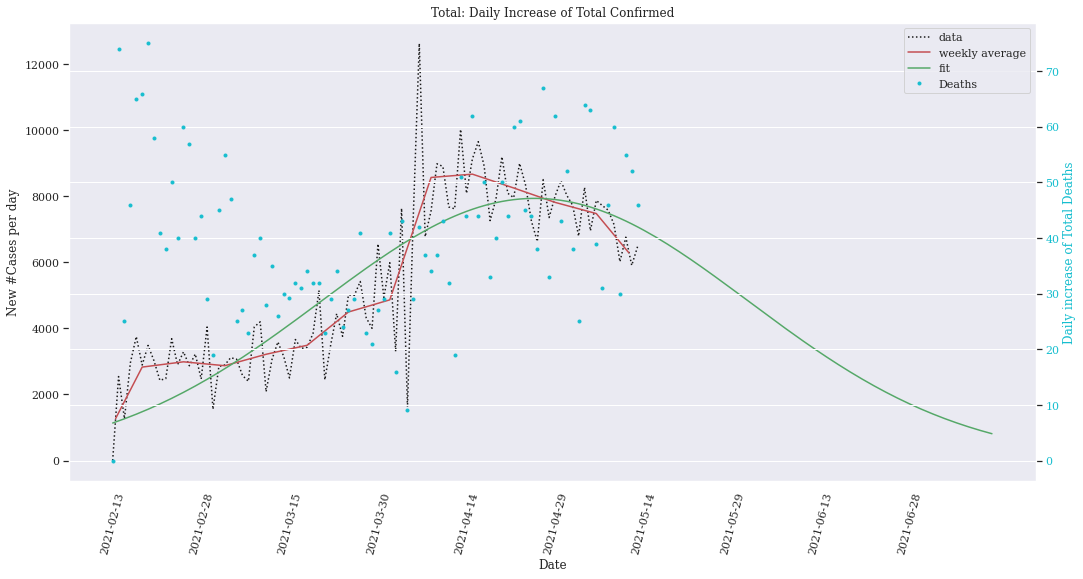



****** ON ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-05-09       ON         492303.0        8308.0         451591.0   
2021-05-10       ON         495019.0        8327.0         454701.0   
2021-05-11       ON         497092.0        8342.0         457599.0   
2021-05-12       ON         499412.0        8374.0         461076.0   
2021-05-13       ON         502171.0        8405.0         464531.0   

            Total Active  
Date                      
2021-05-09       32404.0  
2021-05-10       31991.0  
2021-05-11       31151.0  
2021-05-12       29962.0  
2021-05-13       29235.0  


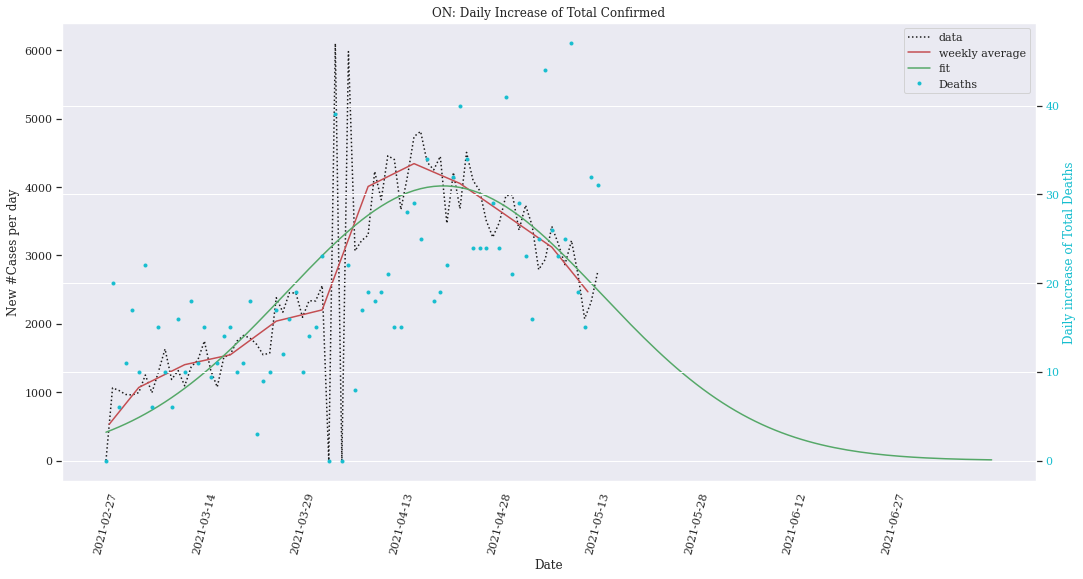



****** QC ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-05-09       QC         358134.0       10987.0         338628.0   
2021-05-10       QC         358796.0       10993.0         339660.0   
2021-05-11       QC         359456.0       11002.0         340637.0   
2021-05-12       QC         360201.0       11012.0         341433.0   
2021-05-13       QC         360982.0       11017.0         342170.0   

            Total Active  
Date                      
2021-05-09        8519.0  
2021-05-10        8143.0  
2021-05-11        7817.0  
2021-05-12        7756.0  
2021-05-13        7795.0  


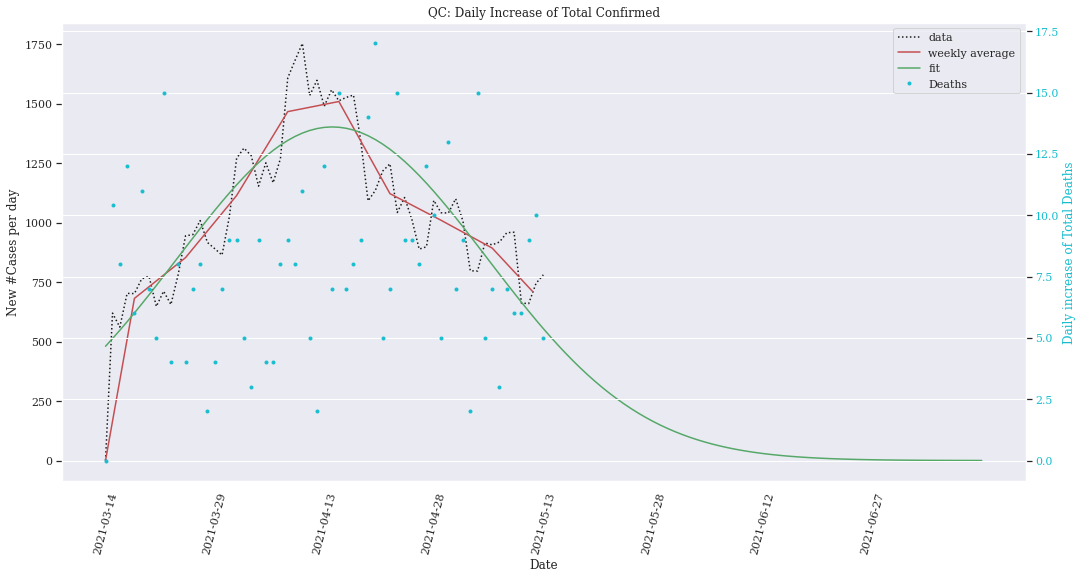



****** BC ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-05-09       BC         134341.0        1602.0         125799.0   
2021-05-10       BC         134341.0        1602.0         125799.0   
2021-05-11       BC         136100.0        1622.0         128139.0   
2021-05-12       BC         136623.0        1624.0         128782.0   
2021-05-13       BC         137223.0        1627.0         129524.0   

            Total Active  
Date                      
2021-05-09        6743.0  
2021-05-10        6743.0  
2021-05-11        6140.0  
2021-05-12        6020.0  
2021-05-13        5885.0  


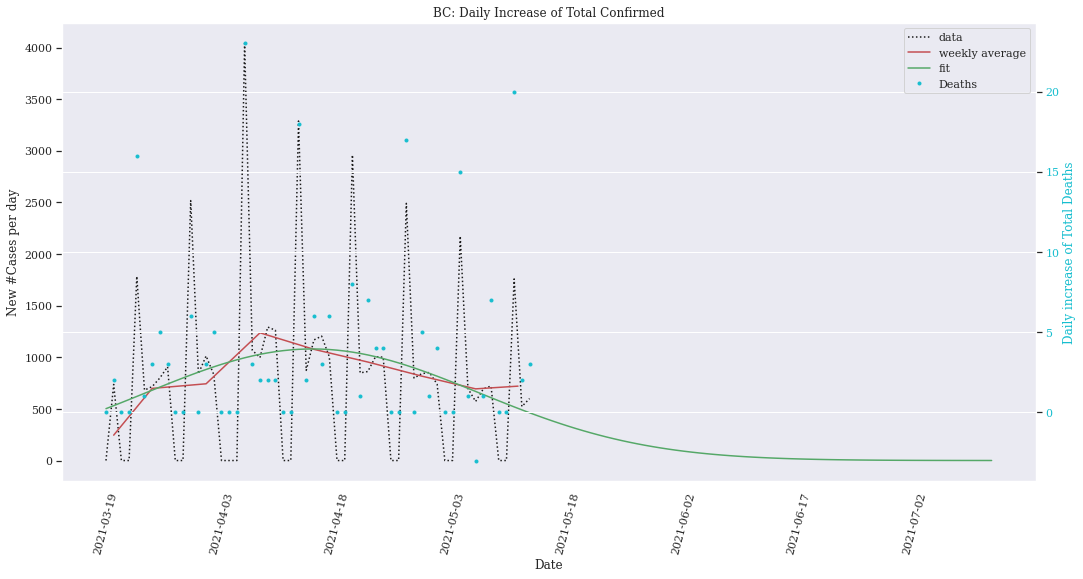



****** AB ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-05-09       AB         207157.0        2108.0         179894.0   
2021-05-10       AB         208790.0        2110.0         181483.0   
2021-05-11       AB         210387.0        2117.0         182832.0   
2021-05-12       AB         211836.0        2119.0         184719.0   
2021-05-13       AB         213635.0        2123.0         186550.0   

            Total Active  
Date                      
2021-05-09       25155.0  
2021-05-10       25197.0  
2021-05-11       25438.0  
2021-05-12       24998.0  
2021-05-13       24962.0  


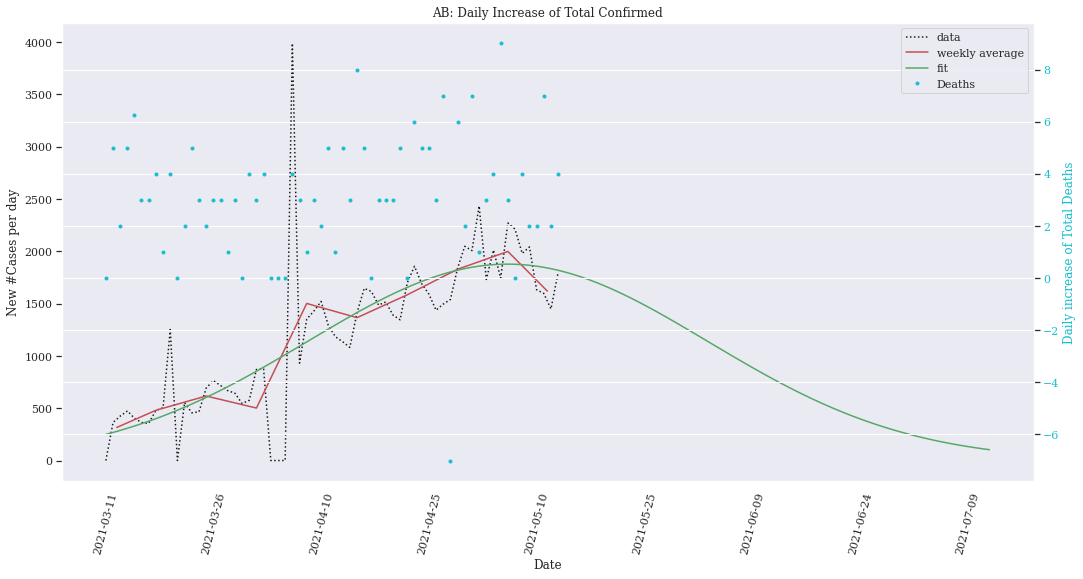

In [494]:
for cur_df in df:
    #define main axis parameter
    data_examined = cur_df.columns.get_loc('Total Confirmed')
    #define secondary axis parameter
    second_param = 'Total Deaths'
    
    ydata = cur_df.iloc[:, data_examined].transpose()
    xdata = cur_df.index
    
    # 2021-04-16 added #########################
    # ignore the first 340 data points to look at the 3rd wave
    start_point = 340
    xdata = xdata[start_point:]
    ydata = ydata[start_point:]
    ############################################
    
    xdata = xdata[~ydata.apply(np.isnan)]
    ydata = ydata[~ydata.apply(np.isnan)]#ydata.replace(np.nan, '', regex=False)
    
    x_data_2 = [try_parsing_date(x) for x in xdata]
    year_start = x_data_2[0].year
    
    # convert time to days since first record
    x_data_in_sec = [int(x.timestamp()) - int(x_data_2[0].timestamp()) for x in x_data_2]
    x_data_in_day  = np.array([x / 3600 / 24 for x in x_data_in_sec])
    
    # compute the increase in confirmed cases from total
    x_data_in_day_diff = np.ediff1d(x_data_in_day, to_begin=0)
    y_data_change = np.ediff1d(ydata, to_begin=0)
    y_data_change_per_day = np.array([division(y,x) for y,x in 
                                      zip(y_data_change,x_data_in_day_diff)])
    
    # compute the weekly average
    weekly_avg = getWeeklyAverage(xdata, x_data_in_day, y_data_change_per_day, year_start)
    
    # ignore datapoints where count is zero
    #nonzero_indices = np.where(y_data_change_per_day != 0.0)[0]
    #x_data_in_day = x_data_in_day[nonzero_indices]
    #y_data_change_per_day = y_data_change_per_day[nonzero_indices]

    
    print('\n\n****** ' + cur_df['Province'][0] + ' ******')
    print(cur_df.tail(5))
    
    
    # compute the curvefit
    n = len(x_data_in_day)
    mean = float(sum(y_data_change_per_day))/n
    sigma = np.sqrt(sum((y_data_change_per_day-mean)**2))/np.sqrt(n-1)
    init_vals = [10000, mean, sigma]
       
    # fit your data and getting fit parameters
    popt, pcov = curve_fit(func_normal, x_data_in_day, y_data_change_per_day, 
                           p0=init_vals, maxfev = 100000)
    
    
    # Create the figures
    x_end = math.ceil(x_data_in_day[len(x_data_in_day)-1])
    x_extend = np.array(range(x_end, x_end+61))
    
    xdisplay = [ (try_parsing_date(cur_df.index[start_point]) + 
                  timedelta(days=t)).strftime("%Y-%m-%d") for t in range(0,max(x_extend))]
        
    fig, ax = plt.subplots(figsize=(15,8))
    #plt.clf()
    
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'figure.autolayout': True, 
                         'font.size': 5, 
                         'font.family': 'serif', 
                         'font.sans-serif': ['Helvetica']})    
    
    lns1 = ax.plot(x_data_in_day, y_data_change_per_day, 'k:', label='data')
    
    lns2 = ax.plot(weekly_avg['Week_midpoint'], weekly_avg['Daily_Increase'], 
             'r-', label = 'weekly average')
    
    lns3 = ax.plot(np.concatenate((x_data_in_day, x_extend)), 
             func_normal(np.concatenate((x_data_in_day, x_extend)), *popt), 
             'g-', label='fit')
    
    plt.xticks(np.arange(x_data_in_day[0], max(x_data_in_day) + max(x_extend), step = 15), 
           labels = xdisplay[::15], rotation=75)
    
    ##secondary axis
    # fit your data and getting fit parameters
    ydata_2ndry = cur_df[second_param].fillna(value = 0, inplace = False)[start_point:]
    ydata_2ndry_change = np.ediff1d(ydata_2ndry, to_begin=0)
    ydata_2ndry_change_per_day = np.array([division(float(y),float(x)) for y,x in 
                                      zip(ydata_2ndry_change,x_data_in_day_diff)])
    #popt2, pcov2 = curve_fit(func_normal, x_data_in_day, ydata_2ndry, 
    #                       p0=init_vals, maxfev = 100000)
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:cyan'
    ax2.set_ylabel('Daily increase of ' + second_param, color=color)
    lns4 = ax2.plot(x_data_in_day, ydata_2ndry_change_per_day, 'c.', 
                    color=color, label= 'Deaths')
    #ax2.plot(np.concatenate((x_data_in_day, x_extend)), 
    #         func_normal(np.concatenate((x_data_in_day, x_extend)), *popt2), 
    #         'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    ax.grid()
    ax.set_xlabel('Date')
    ax.set_ylabel('New #Cases per day')
    ax.set_title(cur_df['Province'][0] + ': Daily Increase of ' + cur_df.columns[data_examined])
    plt.show()
    
    from sklearn.metrics import mean_squared_error
    # Calculation of Mean Squared Error (MSE) 
    y_pred = np.array(func_normal(x_data_in_day, *popt))
    #print("MSE: {}".format(mean_squared_error(y_data_change_per_day, y_pred)))


## 2nd model: Linear Regression on Cum. Cases in Logarithmic scale

In [457]:
#for cur_df in df[0:1][:]:
cur_df = df[0][:]            #only look at all the cases in Canada

#get today's date and time
today = (datetime.today() - try_parsing_date(cur_df.index[0])).days

#format x and y data for plot
xdata = cur_df.index
x_data_2 = [try_parsing_date(x) for x in xdata]
ydata = cur_df.iloc[:, 1]#.transpose()

#remove NaN elements
temp_ind = np.argwhere(~np.isnan(ydata.to_list()))
ydata = [ydata.to_list()[int(x)] for x in temp_ind]
x_data_2 = [x_data_2[int(x)] for x in temp_ind]

x_data_in_sec = [int(x.timestamp()) - int(x_data_2[0].timestamp()) for x in x_data_2]
x_data_in_day  = [x / 3600 / 24 for x in x_data_in_sec]

# ignore the first 390 data points to look at the 2nd wave
start_point = 390
x_data_in_day = x_data_in_day[start_point:]
ydata = ydata[start_point:]

# Covid19 Vaccine Distribution

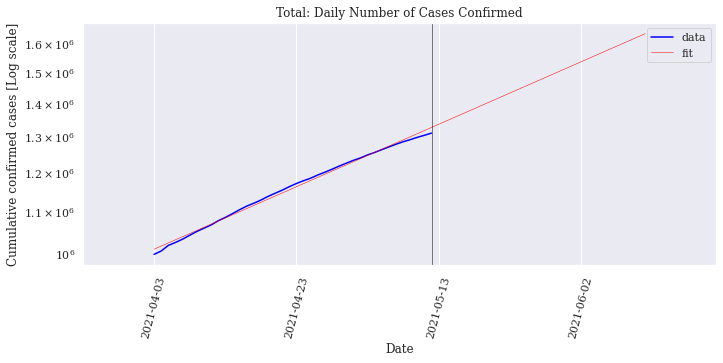

In [458]:
# curve fit, in log scale for y
#1.
#m = False
#2.
m, c = np.polyfit(x_data_in_day, np.log(ydata), 1) # fit log(y) = m*log(x) + c

#Plot: log scale in y-axis
fig,ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_yscale('log', basey=10)

x_end = math.ceil(x_data_in_day[len(x_data_in_day)-1])
x_extend = np.array(range(x_end, x_end+31))

# calculate the fitted values of y
if (m != False):
    y_fit = np.exp([m*x + c for x in np.concatenate((x_data_in_day, x_extend))])

xdisplay = [ (try_parsing_date(cur_df.index[0])
              + timedelta(days=t)).strftime("%Y-%m-%d") 
            for t in range(int(x_data_in_day[0]), max(x_extend))]

plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'figure.autolayout': True, 
                     'font.size': 5, 
                     'font.family': 'serif', 
                     'font.sans-serif': ['Helvetica']})    


plt.plot(x_data_in_day, ydata, color = 'blue', label='data')
if (m != False):
    plt.plot(np.concatenate((x_data_in_day, x_extend)), 
            y_fit, color = 'red', linewidth=0.5, label='fit')
plt.axvline(x=today, color = 'black', linewidth=0.5)

plt.xticks(np.arange(min(x_data_in_day), max(x_data_in_day) + max(x_extend), step = 20), 
           labels = xdisplay[::20], rotation=75)
plt.yticks(np.arange(10^6, 2*10^6, step = 5*10^5), 
           labels = np.arange(10^6, 2*10^6, step = 5*10^5))

plt.xlim(min(x_data_in_day)-10, max(x_extend)+10)
#if (m != False):
#    plt.ylim(min(ydata)/1.5, max(y_fit)*1.5)

plt.xlabel('Date')
plt.ylabel('Cumulative confirmed cases [Log scale]')
plt.title(cur_df['Province'][0] + ': Daily Number of Cases Confirmed')
plt.legend()
plt.show()

In [459]:
import os
import pandas as pd
import selenium
from selenium import webdriver
import time
from PIL import Image
import io
import requests
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
#from selenium.common.exceptions import ElementClickInterceptedException
#import chromedriver_binary

In [460]:
# Extracts data from the webpage using selenium
def extract_table2(url, xpath_header, xpath_content):
    # Install Driver
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)

    try:
        element = WebDriverWait(driver, 60).until(
            EC.presence_of_element_located((By.XPATH, xpath_content))
        )
        #extracting data
        header = driver.find_elements_by_xpath(xpath_header)  #NOT driver.find_element_by_xpath()
        table = driver.find_elements_by_xpath(xpath_content)  #NOT driver.find_element_by_xpath()
    except:
        print("Issue with extracting info from the Chrome Browser. Please check")
        os. _exit()

    trow = []
    for num_row in range(len(table)):
        trow.append(table[num_row].text)
    theader = []
    for each_header in range(len(header)):
        theader.append(header[each_header].text)
        
    # print info
    #print(trow)
    #print(theader)
    
    data = [[x.split('\n')[0]] + x.split('\n')[1].split(' ', 6) for x in trow]
    #print(data)
    # Create dataframe
    df = pd.DataFrame(data, columns = theader)
    #df
    # close chrome
    driver.quit()

    return df

In [461]:
### Export the current df to existing file (previous data)
def save_dataset(save_path, df_1):
    os.makedirs(save_path, exist_ok = True)
    num_dataset = len(df_1.index)

    for i in range(num_dataset):
        temp_df = df_1.loc[df_1[df_1.columns[0]] == df_1.loc[i][df_1.columns[0]]]

        #load current df and then perform merge before saving
        file_fullpath = os.path.join(save_path,df_1.loc[i][df_1.columns[0]] + ".csv")
        if os.path.exists(file_fullpath):
            orig_dataset = pd.read_csv(file_fullpath, dtype = object)

            # run if need to update the header
            #orig_dataset.columns = temp_df.columns
            
            #reindex new df to match with existing data
            temp_df.reindex(columns=orig_dataset.columns)
            
            #print(orig_dataset)
            #print(dict(orig_dataset.dtypes))
            #print(temp_df)
            #print(dict(temp_df.dtypes))
            
            new_dataset = pd.merge(orig_dataset, temp_df, how = 'outer', 
                                   on = list(orig_dataset.columns))

            
            new_dataset.drop_duplicates(subset=list(orig_dataset.columns), 
                                        keep = 'first', inplace = True)
            #print(new_dataset)
            new_dataset.to_csv(file_fullpath, index = False)
        else:
            temp_df.to_csv(file_fullpath, index = False)

In [462]:
#Specify Search URL 
url='https://www.ctvnews.ca/health/coronavirus/coronavirus-vaccine-tracker-how-many-people-in-canada-have-received-shots-1.5247509'
#url='https://www.python.org'

#old xpath
# xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/thead/th'
# xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/tbody/tr'
#paths updated on March 6th
#xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[4]/table/thead/th'
#xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[4]/table/tbody/tr'
#paths updated on March 26th: new column
xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/thead/th'
xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/tbody/tr'

#Extract data and store into a dataframe
df_vac = extract_table2(url, xpath2_header, xpath2_content)


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 90.0.4430
[WDM] - Get LATEST driver version for 90.0.4430


[WDM] - Get LATEST driver version for 90.0.4430
[WDM] - Trying to download new driver from https://chromedriver.storage.googleapis.com/90.0.4430.24/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\Powell\.wdm\drivers\chromedriver\win32\90.0.4430.24]


In [463]:
df_vac

,Province/Territory,% of population vaccinated (at least one dose),% of eligible population (16+),First doses,Second doses,Received from manufacturer,Received doses administered,Updated
0,Yukon,63.7%,77.7%,"26,778","23,492","57,020",88.2%,May. 12
1,Northwest Territories,60.5%,76.9%,"27,310","22,501","60,000",83.0%,May. 10
2,Quebec,44.4%,53.3%,"3,804,396","210,447","4,578,079",87.7%,May. 13
3,Ontario,42.2%,50.6%,"6,221,763","407,600","7,832,125",84.6%,May. 13
4,British Columbia,42.0%,49.4%,"2,162,023","115,295","2,657,520",85.7%,May. 12
5,Nunavut,41.9%,62.8%,"16,471","12,931","45,100",65.2%,May. 11
6,Canada,41.6%,50.1%,"15,824,139","1,328,284","19,877,844",86.3%,May. 13
7,Saskatchewan,41.6%,52.5%,"490,274","46,770","573,935",93.6%,May. 12
8,Newfoundland and Labrador,39.1%,45.6%,"203,992","9,686","269,650",79.2%,May. 12
9,Manitoba,38.2%,47.8%,"526,731","78,824","686,160",88.3%,May. 13


In [464]:
#Save data on vaccine
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data","vaccine")
save_dataset(save_path, df_vac)

In [465]:
#END